### Good book for deep learning engineers:
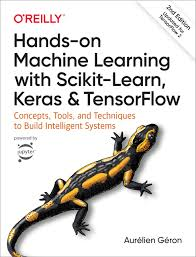

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

### A simple example

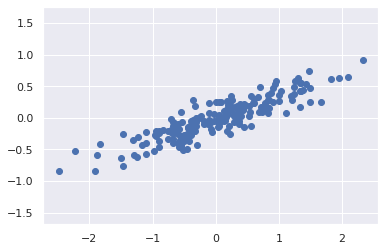

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables. In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [ ]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [ ]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

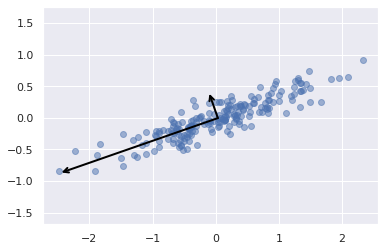

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0,color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

### PCA for visualization: Hand-written digits

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [ ]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


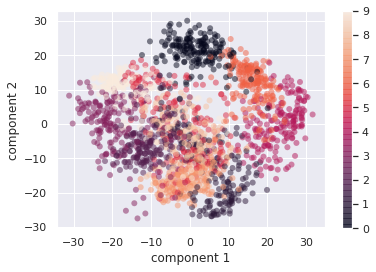

In [ ]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### Our implementation of PCA

### Let's calculate the covariance matrix

In [ ]:
X=digits.data
C=np.cov(X.T)
C.shape

(64, 64)

### Specify training parameters

In [ ]:
iteration_number=100
etha=.001 # learning rate
k=2  # desired dimensionality



### Define objective function

In [ ]:
def Objective(W):
  return (1/X.shape[0])*np.trace(W.T@C@W)



### Derivative of objective function

In [ ]:
def Derivative(W):
  return 2*C@W


# Finding the closest orthogonal matrix to the current W (Projection on Stiefel manifold)

In [ ]:
def Proj(W):
  U,sig,V_t=np.linalg.svd(W)
  return U@np.eye(U.shape[1],V_t.shape[1])@V_t

### Generate a random orthogonal matrix to initialize W

In [ ]:
a = np.random.random(size=(X.shape[1], k))
from scipy.linalg import orth
W = orth(a)


In [ ]:
objs=np.zeros((iteration_number))
for i in range(iteration_number):
  objs[i]=Objective(W)
  print('objective value in iteration {} is {}'.format(i+1, objs[i]))
  W=W+etha*Derivative(W) # gradient step
  W=Proj(W) # projection step
  

objective value in iteration 1 is 0.028091898006530218
objective value in iteration 2 is 0.03581877988870735
objective value in iteration 3 is 0.046318303478697816
objective value in iteration 4 is 0.05972555848736858
objective value in iteration 5 is 0.07555049037234368
objective value in iteration 6 is 0.09276654541464398
objective value in iteration 7 is 0.11021590962006263
objective value in iteration 8 is 0.12692015962909506
objective value in iteration 9 is 0.14208555715332544
objective value in iteration 10 is 0.15506665018526192
objective value in iteration 11 is 0.16548551940463987
objective value in iteration 12 is 0.17334695977580653
objective value in iteration 13 is 0.178980680775222
objective value in iteration 14 is 0.18286718697498705
objective value in iteration 15 is 0.18548190653275481
objective value in iteration 16 is 0.18721576185253597
objective value in iteration 17 is 0.18835813182066474
objective value in iteration 18 is 0.1891103352252174
objective value in i

Text(0, 0.5, 'Objective value')

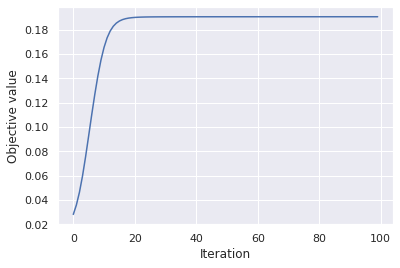

In [ ]:
plt.plot(objs)
plt.xlabel("Iteration")
plt.ylabel("Objective value")

### Does the projectoin matrix is orthogonal ?

In [ ]:
print(W.T@W)

[[ 1.00000000e+00 -2.43846961e-17]
 [-2.43846961e-17  1.00000000e+00]]


### Let's reduce the dimensionality using our projection matrix "W"

In [ ]:
projected2=X@W

### Let's compare our method with sklearn

[Text(0, 0.5, 'component 2'), Text(0.5, 0, 'component 1')]

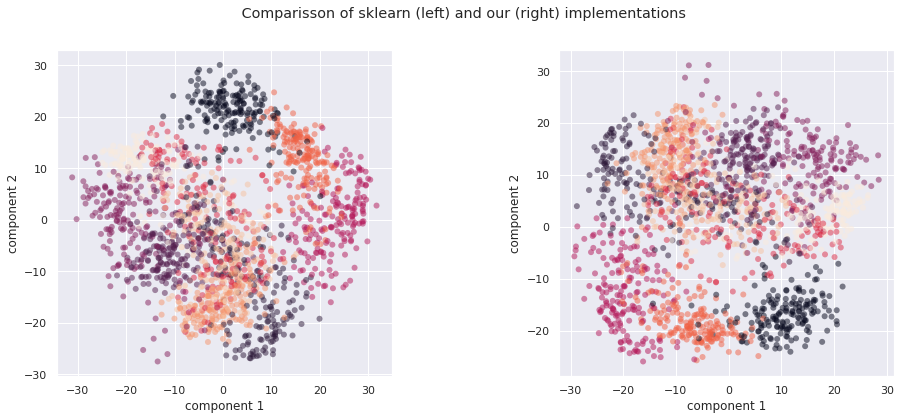

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
fig.subplots_adjust(wspace=.5)
fig.suptitle(' Comparisson of sklearn (left) and our (right) implementations')
ax1.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5)
ax1.set(xlabel='component 1', ylabel='component 2')


ax2.scatter(projected2[:, 0], projected2[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5)
ax2.set(xlabel='component 1', ylabel='component 2')


### Let's compare them more quantitatively !

In [ ]:
print('The objective for sklearn implementation is',np.trace(projected.T@projected))
print('The objective for our implementation is',np.trace(projected2.T@projected2))

The objective for sklearn implementation is 615533.519852588
The objective for our implementation is 620970.8171340689


### Choosing the number of components
A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

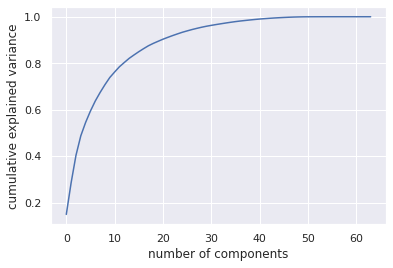

In [ ]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first  N  components. For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## PCA as Noise Filtering
PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.



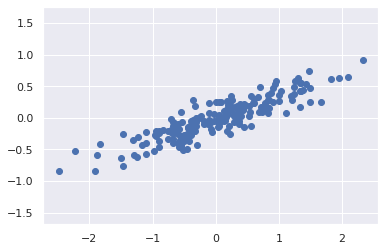

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [ ]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

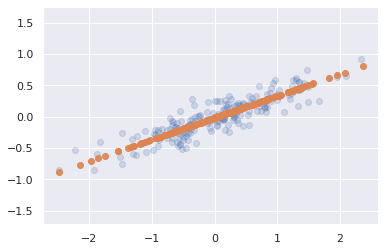

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.9)
plt.axis('equal');


## Let's see how noise removal looks with the digits data.
First we will plot several of the input noise-free data:

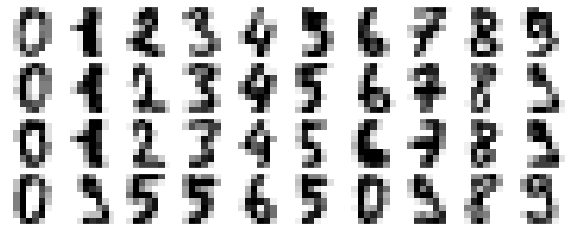

In [ ]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now lets add some random noise to create a noisy dataset, and re-plot it:

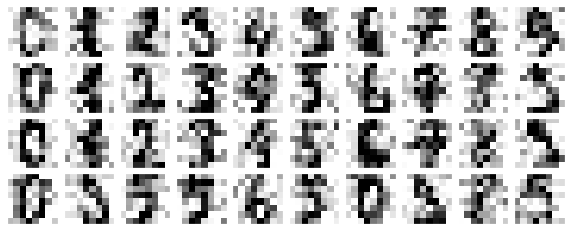

In [ ]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels.
Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

In [ ]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components. Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

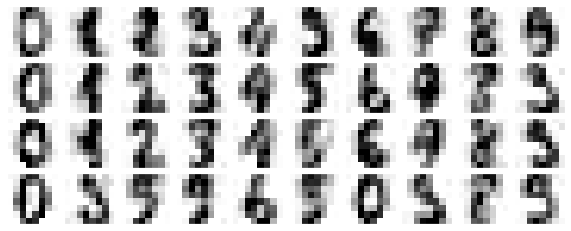

In [ ]:
components= pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

# Conclusions

We learnt how to apply PCA using sklearn \\
We implemented our PCA using projeted gradient algorithm \\
We learnt a way to specify number of principal components \\
We learnt to employ PCA for dimensionalirt reduction and noise removal


# References
Python Data Science Handbook (notebook for PCA)


Proof of projection on Stiefel manifold can be found here:

Manton, Jonathan H. "Optimization algorithms exploiting unitary constraints." IEEE Transactions on Signal Processing 50.3 (2002): 635-650.
